# eICU Collaborative Research Database

# Notebook 6: An example project

This notebook introduces a project focused on acute kidney injury, quantifying differences between patients with and without the condition.

## Load libraries and connect to the database

In [0]:
# Import libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path

# Make pandas dataframes prettier
from IPython.display import display, HTML

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

In [0]:
# authenticate
auth.authenticate_user()

In [0]:
# Set up environment variables
project_id='sccm-datathon'
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id

## Define the cohort

Our first step is to define the patient population we are interested in. For this project, we'd like to identify those patients with any past history of renal failure and compare them with the remaining patients.

First, we extract all patient unit stays from the patient table.


In [0]:
# Link the patient and apachepatientresult tables on patientunitstayid
# using an inner join.
%%bigquery icu_stay

SELECT *
FROM `sccm-datathon.team8.icu_stay_hour`

In [0]:
icu_stay.head()

,icustay_id,gender,admission_age,ethnicity,los_icu,los_icu_hour
0,252051,M,28,UNKNOWN/NOT SPECIFIED,6.0,148.0
1,252947,M,25,WHITE,7.0,167.0
2,232160,F,25,WHITE,7.0,172.0
3,256090,M,30,UNKNOWN/NOT SPECIFIED,7.0,189.0
4,224803,M,31,WHITE,4.0,110.0


In [0]:
icu_stay[icu_stay['los_icu_hour']==0]

,icustay_id,gender,admission_age,ethnicity,los_icu,los_icu_hour
311,244500,F,18,BLACK/AFRICAN AMERICAN,0.0,0.0
4614,284516,M,43,WHITE,0.0,0.0
6587,271088,F,48,WHITE,0.0,0.0
7121,240785,M,49,WHITE - OTHER EUROPEAN,0.0,0.0
7472,201934,F,50,WHITE,0.0,0.0
7970,284434,F,51,WHITE,0.0,0.0
8510,216366,M,52,HISPANIC OR LATINO,0.0,0.0
9678,251228,M,54,WHITE,0.0,0.0
17592,242558,F,66,WHITE,0.0,0.0
17689,226872,F,66,WHITE,0.0,0.0


In [0]:
df=icu_stay[icu_stay['los_icu_hour']<500]

(array([15871.,  8370.,  2864.,  1368.,   861.,   629.,   442.,   348.,
          272.,   177.]),
 array([  0. ,  49.9,  99.8, 149.7, 199.6, 249.5, 299.4, 349.3, 399.2,
        449.1, 499. ]),
 <a list of 10 Patch objects>)

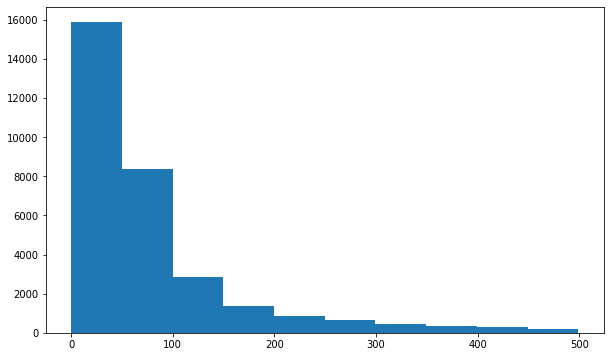

In [0]:
plt.figure(figsize=[10,6])
xi = np.arange(0,500,3)
plt.hist(df['los_icu_hour'])

In [0]:
%%bigquery demo

SELECT *
FROM `sccm-datathon.team8.final_cohort_demographic_info`

In [0]:
demo.head()

,icustay_id,dialysis_flag,dialysis_starttime,death_hosp,gender,age,los_hospital_day,los_icu_day,admission_type,ethnicity,sofa,apsiii,height,weight,bmi,first_careunit,intime
0,200009,0,NaN,0,F,47,6,2,ELECTIVE,WHITE,3,26,161.29,87.2,33.52,CSRU,2189-11-30 10:34:32
1,200025,0,NaN,0,M,49,6,3,EMERGENCY,WHITE,2,21,193.04,140.4,37.68,CSRU,2113-08-25 09:29:12
2,200072,0,NaN,0,M,56,25,3,EMERGENCY,WHITE,0,24,182.00,122.9,37.10,SICU,2106-03-03 19:39:49
3,200119,0,NaN,1,F,50,1,1,EMERGENCY,UNKNOWN/NOT SPECIFIED,9,68,163.83,67,24.96,CCU,2173-06-29 01:50:00
4,200159,0,NaN,0,M,61,10,5,ELECTIVE,HISPANIC/LATINO - DOMINICAN,6,29,142.24,75,37.07,SICU,2134-02-17 18:29:55


In [0]:
demo[(demo['dialysis_flag']==1) & (demo['death_hosp'] == 1)]

,icustay_id,dialysis_flag,dialysis_starttime,death_hosp,gender,age,los_hospital_day,los_icu_day,admission_type,ethnicity,sofa,apsiii,height,weight,bmi,first_careunit,intime
106,205668,1,147.0,1,M,77,9,7,EMERGENCY,UNKNOWN/NOT SPECIFIED,7,48,142.24,75.4,37.27,CSRU,2159-05-10 07:53:00
110,205768,1,73.0,1,M,64,34,33,EMERGENCY,UNKNOWN/NOT SPECIFIED,6,95,166.37,73.5,26.55,CSRU,2132-08-08 09:30:46
114,205948,1,62.0,1,M,70,6,6,EMERGENCY,WHITE,8,68,193.00,120.1,32.24,MICU,2163-04-19 02:21:14
346,216626,1,4.0,1,M,51,1,1,URGENT,WHITE,10,74,191.00,144,39.47,CCU,2201-03-07 09:36:26
374,217970,1,50.0,1,F,87,9,7,EMERGENCY,WHITE,9,59,150.00,56,24.89,CSRU,2200-01-25 13:18:26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31469,276935,1,99.0,1,F,55,27,12,EMERGENCY,AMERICAN INDIAN/ALASKA NATIVE,10,63,170.18,50,17.26,SICU,2109-01-11 13:55:00
31507,280608,1,112.0,1,F,49,12,11,EMERGENCY,WHITE,12,79,170.18,94.2,32.53,MICU,2178-03-08 20:41:53
31592,288943,1,23.0,1,M,51,6,5,URGENT,WHITE,12,74,170.18,70,24.17,CSRU,2188-08-13 10:23:40
31619,291353,1,57.0,1,F,77,44,21,ELECTIVE,WHITE,10,60,170.18,64.3,22.20,SICU,2161-12-08 23:26:17


In [0]:
list(demo)

['icustay_id',
 'dialysis_flag',
 'dialysis_starttime',
 'death_hosp',
 'gender',
 'age',
 'los_hospital_day',
 'los_icu_day',
 'admission_type',
 'ethnicity',
 'sofa',
 'apsiii',
 'height',
 'weight',
 'bmi',
 'first_careunit',
 'intime']

In [0]:
demo.drop('intime', axis=1, inplace=True)

KeyError: ignored

In [0]:
dummy_cols = ['gender','ethnicity','admission_type','first_careunit']
x_df_dummy = pd.get_dummies(demo, columns = dummy_cols, drop_first = True)

In [0]:
x_df_dummy.head()

,icustay_id,dialysis_flag,dialysis_starttime,death_hosp,age,los_hospital_day,los_icu_day,sofa,apsiii,height,weight,bmi,gender_M,ethnicity_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ethnicity_ASIAN,ethnicity_ASIAN - ASIAN INDIAN,ethnicity_ASIAN - CAMBODIAN,ethnicity_ASIAN - CHINESE,ethnicity_ASIAN - FILIPINO,ethnicity_ASIAN - JAPANESE,ethnicity_ASIAN - KOREAN,ethnicity_ASIAN - OTHER,ethnicity_ASIAN - THAI,ethnicity_ASIAN - VIETNAMESE,ethnicity_BLACK/AFRICAN,ethnicity_BLACK/AFRICAN AMERICAN,ethnicity_BLACK/CAPE VERDEAN,ethnicity_BLACK/HAITIAN,ethnicity_CARIBBEAN ISLAND,ethnicity_HISPANIC OR LATINO,ethnicity_HISPANIC/LATINO - CENTRAL AMERICAN (OTHER),ethnicity_HISPANIC/LATINO - COLOMBIAN,ethnicity_HISPANIC/LATINO - CUBAN,ethnicity_HISPANIC/LATINO - DOMINICAN,ethnicity_HISPANIC/LATINO - GUATEMALAN,ethnicity_HISPANIC/LATINO - HONDURAN,ethnicity_HISPANIC/LATINO - MEXICAN,ethnicity_HISPANIC/LATINO - PUERTO RICAN,ethnicity_HISPANIC/LATINO - SALVADORAN,ethnicity_MIDDLE EASTERN,ethnicity_MULTI RACE ETHNICITY,ethnicity_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,ethnicity_OTHER,ethnicity_PATIENT DECLINED TO ANSWER,ethnicity_PORTUGUESE,ethnicity_SOUTH AMERICAN,ethnicity_UNABLE TO OBTAIN,ethnicity_UNKNOWN/NOT SPECIFIED,ethnicity_WHITE,ethnicity_WHITE - BRAZILIAN,ethnicity_WHITE - EASTERN EUROPEAN,ethnicity_WHITE - OTHER EUROPEAN,ethnicity_WHITE - RUSSIAN,admission_type_EMERGENCY,admission_type_URGENT,first_careunit_CSRU,first_careunit_MICU,first_careunit_SICU,first_careunit_TSICU
0,200009,0,NaN,0,47,6,2,3,26,161.29,87.2,33.52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,200025,0,NaN,0,49,6,3,2,21,193.04,140.4,37.68,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0
2,200072,0,NaN,0,56,25,3,0,24,182.00,122.9,37.10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
3,200119,0,NaN,1,50,1,1,9,68,163.83,67,24.96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
4,200159,0,NaN,0,61,10,5,6,29,142.24,75,37.07,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### Outlier detection

In [0]:
x_df_dummy.drop(x_df_dummy[x_df_dummy['height']>250].index, inplace=True)
x_df_dummy.drop(x_df_dummy[x_df_dummy['weight']>500].index, inplace=True)
x_df_dummy.drop(x_df_dummy[x_df_dummy['height']<20].index, inplace=True)

In [0]:
x_df_dummy['weight'].min()

Decimal('1')

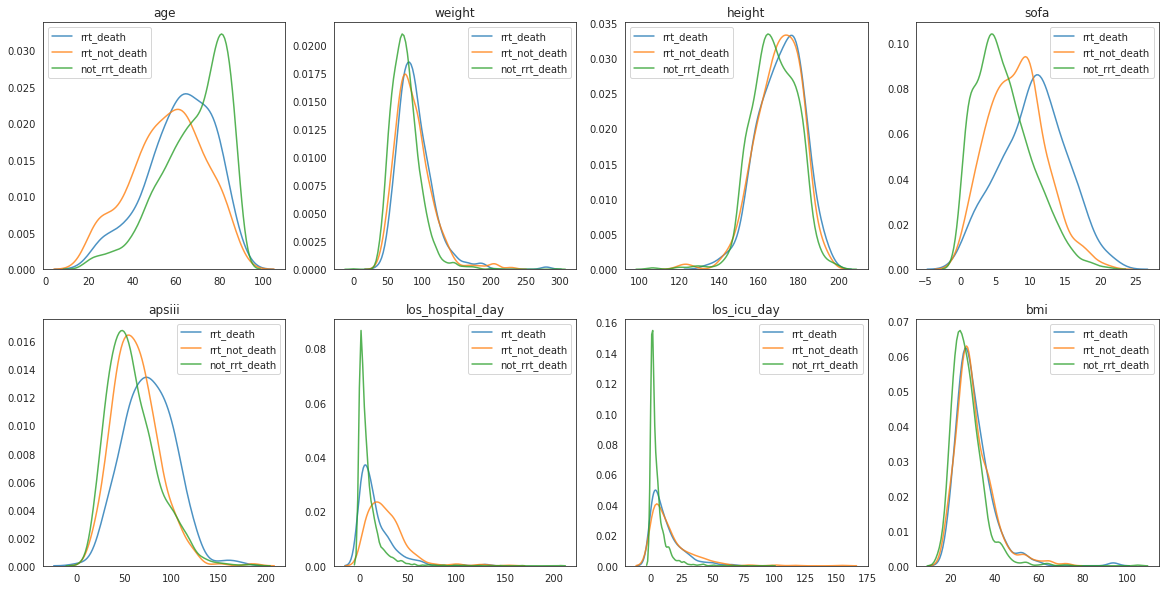

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = ['age','weight','height','sofa','apsiii','los_hospital_day',\
            'los_icu_day', 'bmi']
rrt_death_idx = x_df_dummy[(x_df_dummy['dialysis_flag']==1) & (x_df_dummy['death_hosp'] == 1)].index
rrt_not_death_idx = x_df_dummy[(x_df_dummy['dialysis_flag']==1) & (x_df_dummy['death_hosp'] == 0)].index
not_rrt_death_idx = x_df_dummy[(x_df_dummy['dialysis_flag']==0) & (x_df_dummy['death_hosp'] == 1)].index

sns.set_style("white")
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=[20,10])
axs = axs.flatten()
num_x = x_df_dummy[num_cols]
for i, ax in enumerate(axs):
    pname = num_cols[i]
    predictor = num_x[pname]
    rrt_death = predictor.loc[rrt_death_idx]
    rrt_not_death = predictor.loc[rrt_not_death_idx]
    not_rrt_death = predictor.loc[not_rrt_death_idx]
    ax.set_title(pname)
    sns.kdeplot(ax=ax, data=rrt_death, alpha=0.8, label='rrt_death')
    sns.kdeplot(ax=ax, data=rrt_not_death, alpha=0.8, label='rrt_not_death')
    sns.kdeplot(ax=ax, data=not_rrt_death, alpha=0.8, label='not_rrt_death')

In [0]:
miss_num = x_df_dummy.isnull().sum()

In [0]:
miss_columns = miss_num[miss_num!=0].index
miss_columns

Index(['dialysis_starttime', 'height', 'weight', 'bmi'], dtype='object')

In [0]:
x_df_dummy

,icustay_id,dialysis_flag,dialysis_starttime,death_hosp,age,los_hospital_day,los_icu_day,sofa,apsiii,height,weight,bmi,gender_M,ethnicity_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ethnicity_ASIAN,ethnicity_ASIAN - ASIAN INDIAN,ethnicity_ASIAN - CAMBODIAN,ethnicity_ASIAN - CHINESE,ethnicity_ASIAN - FILIPINO,ethnicity_ASIAN - JAPANESE,ethnicity_ASIAN - KOREAN,ethnicity_ASIAN - OTHER,ethnicity_ASIAN - THAI,ethnicity_ASIAN - VIETNAMESE,ethnicity_BLACK/AFRICAN,ethnicity_BLACK/AFRICAN AMERICAN,ethnicity_BLACK/CAPE VERDEAN,ethnicity_BLACK/HAITIAN,ethnicity_CARIBBEAN ISLAND,ethnicity_HISPANIC OR LATINO,ethnicity_HISPANIC/LATINO - CENTRAL AMERICAN (OTHER),ethnicity_HISPANIC/LATINO - COLOMBIAN,ethnicity_HISPANIC/LATINO - CUBAN,ethnicity_HISPANIC/LATINO - DOMINICAN,ethnicity_HISPANIC/LATINO - GUATEMALAN,ethnicity_HISPANIC/LATINO - HONDURAN,ethnicity_HISPANIC/LATINO - MEXICAN,ethnicity_HISPANIC/LATINO - PUERTO RICAN,ethnicity_HISPANIC/LATINO - SALVADORAN,ethnicity_MIDDLE EASTERN,ethnicity_MULTI RACE ETHNICITY,ethnicity_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,ethnicity_OTHER,ethnicity_PATIENT DECLINED TO ANSWER,ethnicity_PORTUGUESE,ethnicity_SOUTH AMERICAN,ethnicity_UNABLE TO OBTAIN,ethnicity_UNKNOWN/NOT SPECIFIED,ethnicity_WHITE,ethnicity_WHITE - BRAZILIAN,ethnicity_WHITE - EASTERN EUROPEAN,ethnicity_WHITE - OTHER EUROPEAN,ethnicity_WHITE - RUSSIAN,admission_type_EMERGENCY,admission_type_URGENT,first_careunit_CSRU,first_careunit_MICU,first_careunit_SICU,first_careunit_TSICU
0,200009,0,NaN,0,47,6,2,3,26,161.29,87.2,33.52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,200025,0,NaN,0,49,6,3,2,21,193.04,140.4,37.68,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0
2,200072,0,NaN,0,56,25,3,0,24,182.00,122.9,37.10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
3,200119,0,NaN,1,50,1,1,9,68,163.83,67,24.96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
4,200159,0,NaN,0,61,10,5,6,29,142.24,75,37.07,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31718,299580,0,NaN,0,78,12,2,7,38,170.18,77.5,26.76,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0
31719,299659,0,NaN,0,59,2,1,1,27,170.18,59.9,20.68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
31720,299674,1,20.0,1,55,127,9,7,85,170.18,83.5,28.83,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
31721,299780,0,NaN,0,65,15,9,5,64,170.18,64,22.10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0


In [0]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

estimator = ExtraTreesRegressor(n_estimators=10, random_state=0)
imp = IterativeImputer(random_state=0, estimator=estimator)
#miss_columns = ['admissionWeight']
imp.fit(x_df_dummy)
imputed_df = imp.transform(x_df_dummy)
imputed_df = pd.DataFrame(x_df_dummy, columns=x_df_dummy.columns)

In [0]:
%%bigquery creatinine

SELECT *
FROM `sccm-datathon.team8.final_creatinine_compare_results`

In [0]:
creatinine.head()

,icustay_id,dialysis_flag,death_hosp,gender,age,los_hospital_day,los_icu_day,creatinine_change_2d,creatinine_ratio_2d,creatinine_change_7d,creatinine_ratio_7d
0,200063,0,0,M,37,29,27,0.7,1.78,1.7,2.89
1,200071,0,0,F,37,121,1,0.0,1.00,0.4,1.80
2,200085,0,0,M,56,16,3,0.1,1.06,0.1,1.06
3,200098,0,0,M,63,9,4,0.0,1.00,1.3,2.63
4,200099,0,0,M,80,7,2,0.3,1.33,0.7,1.78


In [0]:
#creatinine.sort_values(by=['icustay_id','los_icu_hour'])
#creatinine.drop(creatinine[creatinine['creatinine']>20].index, inplace=True)

In [0]:
#creat_mean = creatinine.groupby('icustay_id').mean()
#creat_mean

In [0]:
#demo_creat = demo.set_index('icustay_id').join(creatinine)
#demo_creat

In [0]:
def conditions(x):
    if x < 1.5:
      return "normal";
    elif ((x >= 1.5) and (x < 2)):
      return "stage1";
    elif ((x >= 2) and (x < 3)):
      return "stage2";
    else:
      return "stage3"

func = np.vectorize(conditions)
stage_class = func(creatinine["creatinine_ratio_7d"])
creatinine["stage_class"] = stage_class

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


Text(0.5, 0, 'Kdigo Stage')

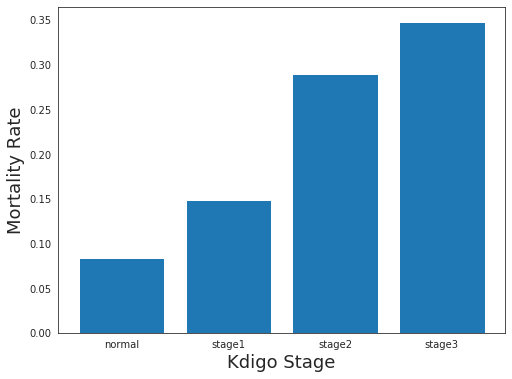

In [0]:
fig1 = plt.figure(figsize=(8,6))
plt.bar(['normal','stage1', 'stage2', 'stage3'], mortality_kidgo)
plt.ylabel('Mortality Rate', fontsize=18)
plt.xlabel('Kdigo Stage', fontsize=18)

In [0]:
creat_kidgo = [0, 1.5, 2, 3]
mortality_kidgo = []
mortality_value_kidgo = []
creat_value_kidgo = [0, 0.3, 4]
for i in range(len(creat_kidgo)-1):
  creat1 = creatinine[(creatinine['creatinine_ratio_7d']>=creat_kidgo[i]) & (creatinine['creatinine_ratio_7d']<creat_kidgo[i+1])]
  mor = creat1['death_hosp'].sum()/len(creat1)
  mortality_kidgo.append(mor)
creat1 = creatinine[(creatinine['creatinine_ratio_7d']>=creat_kidgo[-1])]
mor = creat1['death_hosp'].sum()/len(creat1)
mortality_kidgo.append(mor)

for j in range(len(creat_value_kidgo)-1):
  creat1 = creatinine[(creatinine['creatinine_change_7d']>=creat_kidgo[j]) & (creatinine['creatinine_change_7d']<creat_kidgo[j+1])]
  mor = creat1['death_hosp'].sum()/len(creat1)
  mortality_value_kidgo.append(mor)
creat1 = creatinine[(creatinine['creatinine_ratio_7d']>=creat_kidgo[-1])]
mor = creat1['death_hosp'].sum()/len(creat1)
mortality_value_kidgo.append(mor)
mortality_value_kidgo

[0.09161374368995277, 0.3582554517133956, 0.3473491773308958]

In [0]:
np.arange(0, creatinine['creatinine_ratio_7d'].max(), 0.1)

In [0]:
creat_range = [0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ]
mortality_list = []
mortality_value_list = []

for i in range(len(creat_range)-1):
  creat1 = creatinine[(creatinine['creatinine_ratio_7d']>=creat_range[i]) & (creatinine['creatinine_ratio_7d']<creat_range[i+1])]
  creat2 = creatinine[(creatinine['creatinine_change_7d']>=creat_range[i]) & (creatinine['creatinine_change_7d']<creat_range[i+1])]
  mor1 = creat1['death_hosp'].sum()/len(creat1)
  mor2 = creat2['death_hosp'].sum()/len(creat2)
  mortality_list.append(mor1)
  mortality_value_list.append(mor2)
#creat1 = creatinine[(creatinine['creatinine_ratio_7d']>5)]
#mor = creat1['death_hosp'].sum()/len(creat1)
#mortality_list.append(mor)
#mortality_list

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


Text(0, 0.5, 'Mortality Rate')

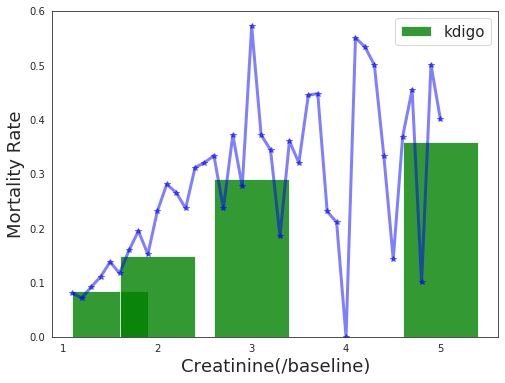

In [0]:
fig2 = plt.figure(figsize=(8,6))
plt.plot(creat_range[1:], mortality_list, alpha=0.5, c='blue', marker='*', linewidth=3)
plt.bar(creat_kidgo[1:], mortality_kidgo, alpha=0.8, color='g', label='kdigo')
plt.legend(fontsize=15)
plt.xlabel('Creatinine(/baseline)', fontsize=18)
plt.ylabel('Mortality Rate', fontsize=18)

In [0]:
mortality_list + np.repeat(0.1,len(mortality_list))

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.18019301, 0.17148973, 0.19168584, 0.21076345, 0.23765978,
       0.21686992, 0.25904936, 0.29459459, 0.25197568, 0.33076923,
       0.38052805, 0.36530612, 0.33622047, 0.41132075, 0.42051282,
       0.43333333, 0.33611111, 0.47096774, 0.37659574, 0.67142857,
       0.47142857, 0.44375   , 0.28518519, 0.46      , 0.42      ,
       0.54444444, 0.54736842, 0.33076923, 0.31052632, 0.1       ,
       0.65      , 0.63333333, 0.6       , 0.43333333, 0.24285714,
       0.46842105, 0.55454545, 0.2       , 0.6       , 0.5       ])

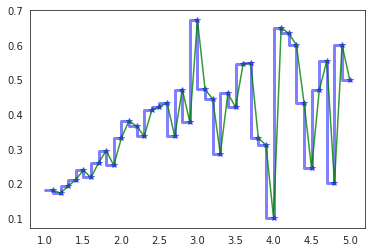

In [0]:
plt.step(creat_range[1:], mortality_list+np.repeat(0.1,len(mortality_list)), alpha=0.5, c='blue', marker='*', linewidth=3)
plt.plot(creat_range[1:], mortality_list+np.repeat(0.1,len(mortality_list)), alpha=0.8, color='g', label='kdigo')

Text(0, 0.5, 'Mortality Rate')

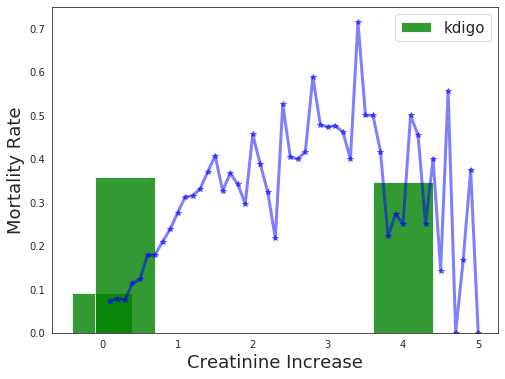

In [0]:
fig3 = plt.figure(figsize=(8,6))
plt.plot(creat_range[1:], mortality_value_list, alpha=0.5, c='blue', marker='*', linewidth=3)
plt.bar(creat_value_kidgo, mortality_value_kidgo, alpha=0.8, color='g', label='kdigo')
plt.legend(fontsize=15)
plt.xlabel('Creatinine Increase', fontsize=18)
plt.ylabel('Mortality Rate', fontsize=18)

In [0]:
plt.hist(height=mortality_value_kidgo, alpha=0.8, color='g', label='kdigo')

TypeError: ignored

In [0]:
creat_value_kidgo = [0, 0.3, 4]

0.0

In [0]:
bs = df_small[df_small['los_icu_hour']==df_small['los_icu_hour'].min()]['creatinine']
bs

297562    1.1
Name: creatinine, dtype: float64

In [0]:
creatinine_pt = np.unique(creatinine['icustay_id'])
creatinine_new = pd.DataFrame(columns=['icustay_id', 'los_icu_hour', 'creatinine','creatinine_ratio'])
for pt in creatinine_pt:
  df_small = creatinine[creatinine['icustay_id']==pt]
  bs = df_small[df_small['los_icu_hour']==df_small['los_icu_hour'].min()]['creatinine']
  #df_small.sort_values(by=['los_icu_hour'])
  #bs = df_small.iloc[0]['creatinine']
  df_small['creatinine_ratio'] = df_small['creatinine']/bs.values[0]
  creatinine_new = pd.concat([creatinine_new, df_small])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
creatinine_new[0:20]

,icustay_id,los_icu_hour,creatinine,creatinine_ratio
60432,200003,6,1.0,1.111111
106831,200003,153,0.6,0.666667
106832,200003,176,0.6,0.666667
106833,200003,224,0.6,0.666667
106834,200003,249,0.6,0.666667
106835,200003,273,0.6,0.666667
106836,200003,297,0.6,0.666667
106837,200003,323,0.6,0.666667
106838,200003,344,0.6,0.666667
106839,200003,369,0.6,0.666667


In [0]:
plt.figure(figsize=[10,6])

xi = np.arange(0,10,0.1)

# get patients who had CRF and plot a histogram
idx = df.loc[df['crf']==1,:].index
plt.hist(cr_first.loc[idx,'labresult'].dropna(), bins=xi, label='With CRF' )

# get patients who did not have CRF
idx = df.loc[df['crf']==0,:].index
plt.hist(cr_first.loc[idx,'labresult'].dropna(), alpha=0.5, bins=xi, label='No CRF' )

plt.legend()

plt.show()

Now we investigate the pasthistory table, and look at all the mentions of past history which contain the phrase 'Renal  (R)' - note we use % as they are wildcard characters for SQL.



In [0]:
%%bigquery ph

SELECT pasthistorypath, count(*) as n
FROM `physionet-data.eicu_crd_demo.pasthistory`
WHERE pasthistorypath LIKE '%Renal  (R)%'
GROUP BY pasthistorypath
ORDER BY n DESC;

In [0]:
for row in ph.iterrows():
    r = row[1]
    print('{:3g} - {:20s}'.format(r['n'],r['pasthistorypath'][48:]))

 61 - Renal  (R)/Renal Failure/renal failure - hemodialysis
 59 - Renal  (R)/Renal Insufficiency/renal insufficiency - creatinine 1-2
 56 - Renal  (R)/Renal Insufficiency/renal insufficiency - baseline creatinine unknown
 43 - Renal  (R)/Renal Failure/renal failure- not currently dialyzed
 30 - Renal  (R)/Renal Insufficiency/renal insufficiency - creatinine 2-3
 16 - Renal  (R)/s/p Renal Transplant/s/p renal transplant
 15 - Renal  (R)/Chronic Stone Disease/chronic kidney stones
 10 - Renal  (R)/Neurogenic Bladder/neurogenic bladder
  8 - Renal  (R)/Renal Insufficiency/renal insufficiency - creatinine 3-4
  6 - Renal  (R)/Renal Insufficiency/renal insufficiency - creatinine > 5
  2 - Renal  (R)/Renal Failure/renal failure - peritoneal dialysis
  2 - Renal  (R)/Renal Insufficiency/renal insufficiency - creatinine 4-5


These all seem like reasonable surrogates for renal insufficiency (note: for a real clinical study, you'd want to be a lot more thorough!).



In [0]:
# identify patients with insufficiency
%%bigquery df_have_crf

SELECT DISTINCT patientunitstayid
FROM `physionet-data.eicu_crd_demo.pasthistory`
WHERE pasthistorypath LIKE '%Renal  (R)%'

In [0]:
df_have_crf['crf'] = 1

In [0]:
# merge the data above into our original dataframe
df = patient.merge(df_have_crf, 
                   how='left', 
                   left_on='patientunitstayid', 
                   right_on='patientunitstayid')

df.head()

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeyear,hospitaldischargetime24,hospitaldischargeoffset,hospitaldischargelocation,hospitaldischargestatus,unittype,unitadmittime24,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid,crf
0,210014,182373,Male,45,Caucasian,73,89,"Hypertension, uncontrolled (for cerebrovascula...",178.0,13:08:59,-8,,2015,15:00:00,4424,Skilled Nursing Facility,Alive,Neuro ICU,13:16:00,Direct Admit,1,admit,116.0,112.7,15:00:00,4424,Skilled Nursing Facility,Alive,002-10665,NaN
1,200026,174624,Male,50,Caucasian,71,87,Ablation or mapping of cardiac conduction pathway,177.8,10:41:00,-311,,2014,18:17:00,1585,Home,Alive,Med-Surg ICU,15:52:00,Operating Room,1,admit,106.1,106.1,17:40:00,1548,Home,Alive,002-10715,NaN
2,221131,190993,Male,83,Caucasian,71,87,"Endarterectomy, carotid",175.3,21:43:00,0,,2014,20:00:00,1337,Home,Alive,Med-Surg ICU,21:43:00,Operating Room,1,admit,NaN,72.1,17:46:00,1203,Home,Alive,002-10249,NaN
3,221215,191054,Male,49,Caucasian,71,87,"Infarction, acute myocardial (MI)",185.4,03:16:00,-829,,2014,19:46:00,1601,Home,Alive,Med-Surg ICU,17:05:00,Emergency Department,1,admit,145.3,146.6,19:07:00,1562,Home,Alive,002-10627,NaN
4,217835,188445,Male,57,Caucasian,73,92,"CABG alone, coronary artery bypass grafting",172.7,01:09:00,-2917,,2014,17:19:00,8133,Home,Alive,CTICU,01:46:00,Operating Room,1,admit,NaN,80.4,08:25:00,4719,Floor,Alive,002-10324,NaN


In [0]:
# impute 0s for the missing CRF values
df.fillna(value=0,inplace=True)
df.head()

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeyear,hospitaldischargetime24,hospitaldischargeoffset,hospitaldischargelocation,hospitaldischargestatus,unittype,unitadmittime24,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid,crf
0,210014,182373,Male,45,Caucasian,73,89,"Hypertension, uncontrolled (for cerebrovascula...",178.0,13:08:59,-8,,2015,15:00:00,4424,Skilled Nursing Facility,Alive,Neuro ICU,13:16:00,Direct Admit,1,admit,116.0,112.7,15:00:00,4424,Skilled Nursing Facility,Alive,002-10665,0.0
1,200026,174624,Male,50,Caucasian,71,87,Ablation or mapping of cardiac conduction pathway,177.8,10:41:00,-311,,2014,18:17:00,1585,Home,Alive,Med-Surg ICU,15:52:00,Operating Room,1,admit,106.1,106.1,17:40:00,1548,Home,Alive,002-10715,0.0
2,221131,190993,Male,83,Caucasian,71,87,"Endarterectomy, carotid",175.3,21:43:00,0,,2014,20:00:00,1337,Home,Alive,Med-Surg ICU,21:43:00,Operating Room,1,admit,0.0,72.1,17:46:00,1203,Home,Alive,002-10249,0.0
3,221215,191054,Male,49,Caucasian,71,87,"Infarction, acute myocardial (MI)",185.4,03:16:00,-829,,2014,19:46:00,1601,Home,Alive,Med-Surg ICU,17:05:00,Emergency Department,1,admit,145.3,146.6,19:07:00,1562,Home,Alive,002-10627,0.0
4,217835,188445,Male,57,Caucasian,73,92,"CABG alone, coronary artery bypass grafting",172.7,01:09:00,-2917,,2014,17:19:00,8133,Home,Alive,CTICU,01:46:00,Operating Room,1,admit,0.0,80.4,08:25:00,4719,Floor,Alive,002-10324,0.0


In [0]:
# set patientunitstayid as the index - convenient for indexing later
df.set_index('patientunitstayid',inplace=True)

## Load creatinine from lab table


In [0]:
%%bigquery lab

SELECT patientunitstayid, labresult
FROM `physionet-data.eicu_crd_demo.lab`
WHERE labname = 'creatinine'

In [0]:
# set patientunitstayid as the index
lab.set_index('patientunitstayid', inplace=True)

In [0]:
# get first creatinine by grouping by the index (level=0)
cr_first = lab.groupby(level=0).first()

# similarly get maximum creatinine
cr_max = lab.groupby(level=0).max()

## Plot distributions of creatinine in both groups


In [0]:
plt.figure(figsize=[10,6])

xi = np.arange(0,10,0.1)

# get patients who had CRF and plot a histogram
idx = df.loc[df['crf']==1,:].index
plt.hist( cr_first.loc[idx,'labresult'].dropna(), bins=xi, label='With CRF' )

# get patients who did not have CRF
idx = df.loc[df['crf']==0,:].index
plt.hist( cr_first.loc[idx,'labresult'].dropna(), alpha=0.5, bins=xi, label='No CRF' )

plt.legend()

plt.show()

While it appears that patients in the red group have higher creatinines, we have far more patients in the blue group (no CRF) than in the red group (have CRF). To alleviate this and allow a fairer comparison, we can normalize the histogram.



In [0]:
plt.figure(figsize=[10,6])

xi = np.arange(0,10,0.1)

# get patients who had CRF and plot a histogram
idx = df.loc[df['crf']==1,:].index
plt.hist( cr_first.loc[idx,'labresult'].dropna(), bins=xi, normed=True,
         label='With CRF' )

# get patients who did not have CRF
idx = df.loc[df['crf']==0,:].index
plt.hist( cr_first.loc[idx,'labresult'].dropna(), alpha=0.5, bins=xi, normed=True,
         label='No CRF' )

plt.legend()

plt.show()

Here we can very clearly see that the first creatinine measured is a lot higher for patients with some baseline kidney dysfunction when compared to those without. Let's try it with the highest value.



In [0]:
plt.figure(figsize=[10,6])

xi = np.arange(0,10,0.1)

# get patients who had CRF and plot a histogram
idx = df.loc[df['crf']==1,:].index
plt.hist( cr_max.loc[idx,'labresult'].dropna(), bins=xi, normed=True,
         label='With CRF' )

# get patients who did not have CRF
idx = df.loc[df['crf']==0,:].index
plt.hist( cr_max.loc[idx,'labresult'].dropna(), alpha=0.5, bins=xi, normed=True,
         label='No CRF' )

plt.legend()

plt.show()

In [0]:
creatinine.head()

,icustay_id,dialysis_flag,death_hosp,gender,age,los_hospital_day,los_icu_day,creatinine_change_2d,creatinine_ratio_2d,creatinine_change_7d,creatinine_ratio_7d,stage_class
0,200063,0,0,M,37,29,27,0.7,1.78,1.7,2.89,stage2
1,200071,0,0,F,37,121,1,0.0,1.00,0.4,1.80,stage1
2,200085,0,0,M,56,16,3,0.1,1.06,0.1,1.06,normal
3,200098,0,0,M,63,9,4,0.0,1.00,1.3,2.63,stage2
4,200099,0,0,M,80,7,2,0.3,1.33,0.7,1.78,stage1


In [0]:
%%bigquery df

SELECT *
FROM `sccm-datathon.team8.final_creatinine_uo_treemodel_results`

In [0]:
df.head()

,icustay_id,dialysis_flag,death_hosp,dialysis_or_death,gender,age,los_hospital_day,los_icu_day,creatinine_max_2d,creatinine_change_2d,creatinine_ratio_2d,creatinine_max_7d,creatinine_change_7d,creatinine_ratio_7d,urine_2d_min,urine_7d_min
0,200063,0,0,0,M,37,29,27,1.6,0.7,1.78,2.6,1.7,2.89,0.361287,0.361287
1,200071,0,0,0,F,37,121,1,0.5,0.0,1.00,0.9,0.4,1.80,0.180676,0.180676
2,200085,0,0,0,M,56,16,3,1.7,0.1,1.06,1.7,0.1,1.06,0.648148,0.191498
3,200098,0,0,0,M,63,9,4,0.8,0.0,1.00,2.1,1.3,2.63,0.172996,0.158228
4,200099,0,0,0,M,80,7,2,1.2,0.3,1.33,1.6,0.7,1.78,0.602904,0.602904


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

df_2d = df[['creatinine_max_2d','creatinine_change_2d','creatinine_ratio_2d',\
            'urine_2d_min','death_hosp']].dropna()
df_2d_train, df_2d_test = train_test_split(df_2d, test_size=.3, 
                     stratify=df_2d[['death_hosp']],
                     random_state=123)

X_train_2d = df_2d_train.drop(["death_hosp"],axis = 1)
y_train_2d = df_2d_train["death_hosp"].values
X_test_2d = df_2d_test.drop(["death_hosp"], axis = 1)
y_test_2d = df_2d_test["death_hosp"].values

In [0]:
df_7d = df[['creatinine_max_7d','creatinine_change_7d','creatinine_ratio_7d',\
            'urine_7d_min','death_hosp']].dropna()
df_7d_train, df_7d_test = train_test_split(df_7d, test_size=.3, 
                     stratify=df_7d[['death_hosp']],
                     random_state=123)

X_train_7d = df_7d_train.drop(["death_hosp"],axis = 1)
y_train_7d = df_7d_train["death_hosp"].values
X_test_7d = df_7d_test.drop(["death_hosp"], axis = 1)
y_test_7d = df_7d_test["death_hosp"].values

[Text(167.4, 195.696, 'X[0] <= 1.675\ngini = 0.179\nsamples = 21956\nvalue = [19780, 2176]'),
 Text(83.7, 152.208, 'X[0] <= 1.45\ngini = 0.137\nsamples = 18800\nvalue = [17413, 1387]'),
 Text(41.85, 108.72, 'X[3] <= 0.68\ngini = 0.129\nsamples = 17705\nvalue = [16482, 1223]'),
 Text(20.925, 65.232, 'X[3] <= 0.011\ngini = 0.153\nsamples = 8604\nvalue = [7885, 719]'),
 Text(10.4625, 21.744, 'gini = 0.483\nsamples = 27\nvalue = [16, 11]'),
 Text(31.387500000000003, 21.744, 'gini = 0.151\nsamples = 8577\nvalue = [7869, 708]'),
 Text(62.775000000000006, 65.232, 'X[1] <= 0.65\ngini = 0.105\nsamples = 9101\nvalue = [8597, 504]'),
 Text(52.3125, 21.744, 'gini = 0.103\nsamples = 9071\nvalue = [8576, 495]'),
 Text(73.2375, 21.744, 'gini = 0.42\nsamples = 30\nvalue = [21, 9]'),
 Text(125.55000000000001, 108.72, 'X[3] <= 0.518\ngini = 0.255\nsamples = 1095\nvalue = [931, 164]'),
 Text(104.625, 65.232, 'X[3] <= 0.517\ngini = 0.314\nsamples = 435\nvalue = [350, 85]'),
 Text(94.16250000000001, 21.744

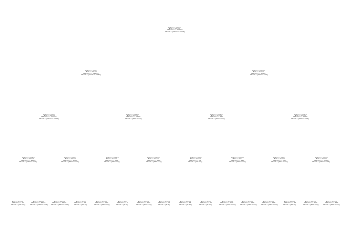

In [0]:
from sklearn.datasets import load_iris
from sklearn import tree

clf1 = tree.DecisionTreeClassifier(max_depth=3)
clf1 = clf1.fit(X_train_2d, y_train_2d)
tree.plot_tree(clf.fit(X_train_2d, y_train_2d)) 

[Text(167.4, 195.696, 'X[0] <= 1.775\ngini = 0.179\nsamples = 21969\nvalue = [19792, 2177]'),
 Text(83.7, 152.208, 'X[3] <= 0.012\ngini = 0.132\nsamples = 18799\nvalue = [17463, 1336]'),
 Text(41.85, 108.72, 'X[3] <= 0.004\ngini = 0.496\nsamples = 66\nvalue = [36, 30]'),
 Text(20.925, 65.232, 'X[3] <= 0.001\ngini = 0.18\nsamples = 10\nvalue = [1, 9]'),
 Text(10.4625, 21.744, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(31.387500000000003, 21.744, 'gini = 0.0\nsamples = 9\nvalue = [0, 9]'),
 Text(62.775000000000006, 65.232, 'X[2] <= 1.09\ngini = 0.469\nsamples = 56\nvalue = [35, 21]'),
 Text(52.3125, 21.744, 'gini = 0.499\nsamples = 23\nvalue = [11, 12]'),
 Text(73.2375, 21.744, 'gini = 0.397\nsamples = 33\nvalue = [24, 9]'),
 Text(125.55000000000001, 108.72, 'X[0] <= 1.375\ngini = 0.13\nsamples = 18733\nvalue = [17427, 1306]'),
 Text(104.625, 65.232, 'X[3] <= 0.591\ngini = 0.116\nsamples = 16264\nvalue = [15259, 1005]'),
 Text(94.16250000000001, 21.744, 'gini = 0.137\nsamples = 90

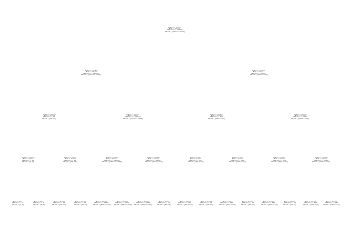

In [0]:
clf2 = tree.DecisionTreeClassifier(max_depth=3)
clf2 = clf2.fit(X_train_7d, y_train_7d)
tree.plot_tree(clf.fit(X_train_7d, y_train_7d)) 

[Text(167.4, 195.696, 'X[0] <= 2.05\ngini = 0.197\nsamples = 21956\nvalue = [19530, 2426]'),
 Text(83.7, 152.208, 'X[0] <= 1.475\ngini = 0.155\nsamples = 19958\nvalue = [18269, 1689]'),
 Text(41.85, 108.72, 'X[3] <= 0.846\ngini = 0.136\nsamples = 17673\nvalue = [16375, 1298]'),
 Text(20.925, 65.232, 'X[2] <= 1.66\ngini = 0.156\nsamples = 10801\nvalue = [9883, 918]'),
 Text(10.4625, 21.744, 'gini = 0.152\nsamples = 10569\nvalue = [9696, 873]'),
 Text(31.387500000000003, 21.744, 'gini = 0.313\nsamples = 232\nvalue = [187, 45]'),
 Text(62.775000000000006, 65.232, 'X[3] <= 5.768\ngini = 0.104\nsamples = 6872\nvalue = [6492, 380]'),
 Text(52.3125, 21.744, 'gini = 0.103\nsamples = 6865\nvalue = [6490, 375]'),
 Text(73.2375, 21.744, 'gini = 0.408\nsamples = 7\nvalue = [2, 5]'),
 Text(125.55000000000001, 108.72, 'X[3] <= 0.416\ngini = 0.284\nsamples = 2285\nvalue = [1894, 391]'),
 Text(104.625, 65.232, 'X[3] <= 0.036\ngini = 0.389\nsamples = 721\nvalue = [530, 191]'),
 Text(94.16250000000001, 

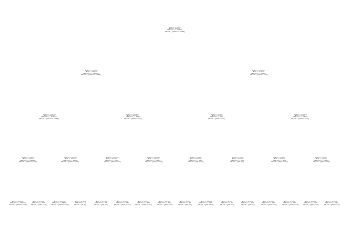

In [0]:
df_2d_2 = df[['creatinine_max_2d','creatinine_change_2d','creatinine_ratio_2d',\
            'urine_2d_min','dialysis_or_death']].dropna()
df_2d_train_2, df_2d_test_2 = train_test_split(df_2d_2, test_size=.3, 
                     stratify=df_2d_2[['dialysis_or_death']],
                     random_state=123)

X_train_2d_2 = df_2d_train_2.drop(["dialysis_or_death"],axis = 1)
y_train_2d_2 = df_2d_train_2["dialysis_or_death"].values
X_test_2d_2 = df_2d_test_2.drop(["dialysis_or_death"], axis = 1)
y_test_2d_2 = df_2d_test_2["dialysis_or_death"].values

clf3 = tree.DecisionTreeClassifier(max_depth=3)
clf3 = clf3.fit(X_train_2d_2, y_train_2d_2)
tree.plot_tree(clf.fit(X_train_2d_2, y_train_2d_2)) 

[Text(167.4, 195.696, 'X[0] <= 2.05\ngini = 0.197\nsamples = 21969\nvalue = [19541, 2428]'),
 Text(83.7, 152.208, 'X[0] <= 1.35\ngini = 0.146\nsamples = 19653\nvalue = [18097, 1556]'),
 Text(41.85, 108.72, 'X[3] <= 0.011\ngini = 0.123\nsamples = 16295\nvalue = [15223, 1072]'),
 Text(20.925, 65.232, 'X[3] <= 0.004\ngini = 0.478\nsamples = 48\nvalue = [29, 19]'),
 Text(10.4625, 21.744, 'gini = 0.278\nsamples = 6\nvalue = [1, 5]'),
 Text(31.387500000000003, 21.744, 'gini = 0.444\nsamples = 42\nvalue = [28, 14]'),
 Text(62.775000000000006, 65.232, 'X[3] <= 0.603\ngini = 0.121\nsamples = 16247\nvalue = [15194, 1053]'),
 Text(52.3125, 21.744, 'gini = 0.144\nsamples = 9269\nvalue = [8545, 724]'),
 Text(73.2375, 21.744, 'gini = 0.09\nsamples = 6978\nvalue = [6649, 329]'),
 Text(125.55000000000001, 108.72, 'X[3] <= 0.011\ngini = 0.247\nsamples = 3358\nvalue = [2874, 484]'),
 Text(104.625, 65.232, 'X[3] <= 0.007\ngini = 0.351\nsamples = 22\nvalue = [5, 17]'),
 Text(94.16250000000001, 21.744, 'gi

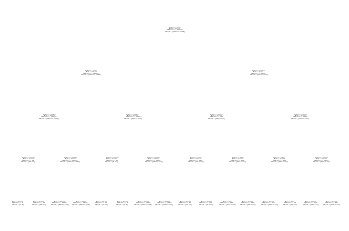

In [0]:
df_7d_2 = df[['creatinine_max_7d','creatinine_change_7d','creatinine_ratio_7d',\
            'urine_7d_min','dialysis_or_death']].dropna()
df_7d_train_2, df_7d_test_2 = train_test_split(df_7d_2, test_size=.3, 
                     stratify=df_7d_2[['dialysis_or_death']],
                     random_state=123)

X_train_7d_2 = df_7d_train_2.drop(["dialysis_or_death"],axis = 1)
y_train_7d_2 = df_7d_train_2["dialysis_or_death"].values
X_test_7d_2 = df_7d_test_2.drop(["dialysis_or_death"], axis = 1)
y_test_7d_2 = df_7d_test_2["dialysis_or_death"].values

clf4 = tree.DecisionTreeClassifier(max_depth=3)
clf4 = clf4.fit(X_train_7d_2, y_train_7d_2)
tree.plot_tree(clf.fit(X_train_7d_2, y_train_7d_2)) 

In [0]:
import graphviz 
import pydotplus
dot_data = tree.export_graphviz(clf1, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris")
dot_data = tree.export_graphviz(clf1, out_file=None, 
                      feature_names=list(X_train_2d),  
                      class_names=['Alive','Dead'],  
                      filled=True, rounded=True,  
                      special_characters=True)   
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('Mortality_first_2days.png')
graph = graphviz.Source(dot_data) 

dot_data = tree.export_graphviz(clf2, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris")
dot_data = tree.export_graphviz(clf2, out_file=None, 
                      feature_names=list(X_train_7d),  
                      class_names=['Alive','Dead'],  
                      filled=True, rounded=True,  
                      special_characters=True)   
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('Mortality_first_7days.png')
graph = graphviz.Source(dot_data) 

dot_data = tree.export_graphviz(clf3, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris")
dot_data = tree.export_graphviz(clf3, out_file=None, 
                      feature_names=list(X_train_2d_2),  
                      class_names=['0','1'],  
                      filled=True, rounded=True,  
                      special_characters=True)   
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('Dialysis_mortality_first_2days.png')
graph = graphviz.Source(dot_data) 

dot_data = tree.export_graphviz(clf4, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris")
dot_data = tree.export_graphviz(clf4, out_file=None, 
                      feature_names=list(X_train_7d_2),  
                      class_names=['0','1'],  
                      filled=True, rounded=True,  
                      special_characters=True)   
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('Dialysis_mortality_first_7days.png')
graph = graphviz.Source(dot_data) 

In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

clf1_probs = clf1.predict_proba(X_test_2d)
# keep probabilities for the positive outcome only
clf1_probs = clf1_probs[:, 1]
# calculate scores
clf_auc1 = roc_auc_score(y_test_2d, clf1_probs)
print('AUC of model1 (Mortality_first_2days):', clf_auc1)

clf2_probs = clf2.predict_proba(X_test_7d)
# keep probabilities for the positive outcome only
clf2_probs = clf2_probs[:, 1]
# calculate scores
clf_auc2 = roc_auc_score(y_test_7d, clf2_probs)
print('AUC of model2 (Mortality_first_7days):',clf_auc2)

clf3_probs = clf3.predict_proba(X_test_2d_2)
# keep probabilities for the positive outcome only
clf3_probs = clf3_probs[:, 1]
# calculate scores
clf_auc3 = roc_auc_score(y_test_2d_2, clf3_probs)
print('AUC of model3 (Dialysis_or_Mortality_first_2days):',clf_auc3)

clf4_probs = clf4.predict_proba(X_test_7d_2)
# keep probabilities for the positive outcome only
clf4_probs = clf4_probs[:, 1]
# calculate scores
clf_auc4 = roc_auc_score(y_test_7d_2, clf4_probs)
print('AUC of model4 (Dialysis_or_Mortality_first_7days):',clf_auc4)

AUC of model1 (Mortality_first_2days): 0.6539907101969167
AUC of model2 (Mortality_first_7days): 0.6613306052240664
AUC of model3 (Dialysis_or_Mortality_first_2days): 0.6835415077694972
AUC of model4 (Dialysis_or_Mortality_first_7days): 0.6887419387213787


In [0]:
clf_probs[clf_probs>0.5]

array([0.8       , 0.7       , 0.8       , 1.        , 0.71428571,
       0.625     , 0.8       , 1.        , 1.        , 0.625     ,
       0.71428571, 0.625     , 0.625     , 0.8       , 1.        ,
       0.625     , 0.8       , 0.625     , 0.66666667, 0.7       ])

In [0]:
demo['weight']

Decimal('1')

In [0]:
%%bigquery kidgo

SELECT *
FROM `sccm-datathon.team8.kidgo_roc_results`

In [301]:
kidgo.head()

,icustay_id,dialysis_flag,death_hosp,dialysis_or_death,kidgo_2d,kidgo_7d
0,200012,0,0,0,0,0
1,200014,0,0,0,0,1
2,200021,0,0,0,0,0
3,200031,0,0,0,0,0
4,200033,0,1,1,0,2


In [305]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, accuracy_score

#fpr_k_2d, tpr_k_2d, threshold_k_2d = roc_curve(kidgo['death_hosp'], kidgo['kidgo_2d'])  
#fpr_k_7d, tpr_k_7d, threshold_k_7d = roc_curve(kidgo['death_hosp'], kidgo['kidgo_7d'])  
auc_k_2d = roc_auc_score(kidgo['death_hosp'], kidgo['kidgo_2d'])
print('Mortality_2day:', auc_k_2d)
auc_k_7d = roc_auc_score(kidgo['death_hosp'], kidgo['kidgo_7d'])
print('Mortality_7day:', auc_k_7d)
auc_k_2d_2 = roc_auc_score(kidgo['dialysis_or_death'], kidgo['kidgo_2d'])
print('Dialysis_Mortality_2day:', auc_k_2d_2)
auc_k_7d_2 = roc_auc_score(kidgo['dialysis_or_death'], kidgo['kidgo_7d'])
print('Dialysis_Mortality_7day:', auc_k_7d_2)


Mortality_2day: 0.5954773124157176
Mortality_7day: 0.5708799891980691
Dialysis_Mortality_2day: 0.6129539185441153
Dialysis_Mortality_7day: 0.58709776351552
